# Начальные модули

In [2]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
#подключение ГПУ
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#для репитативности результатов
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

cuda


In [35]:
#отключение предупреждений
import warnings 
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Чтение из файла для тренировок 

In [153]:
MS_profiles_sintes=pd.read_csv("MS_profiles\MS_profiles_sintes_full_noise_1e-2", sep=';', index_col=0, header=0)
MS_profiles_sintes

,3000.0,3001.0,3002.0,3003.0,3004.0,3005.0,3006.0,3007.0,3008.0,3009.0,...,14993.0,14994.0,14995.0,14996.0,14997.0,14998.0,14999.0,15000.0,15001.0,15002.0
0,0.000000,0.006989,0.009474,0.011865,0.014919,0.013818,0.014891,0.014112,0.011084,0.013803,...,0.002440,0.002064,0.001836,0.001591,0.001053,0.000658,0.000551,0.000000,Bacillus_licheniformis,KUskv2t1(1)
1,0.007313,0.013938,0.014750,0.006966,0.014828,0.012808,0.017923,0.019887,0.002961,0.004370,...,0.005857,0.006673,0.009541,0.010383,0.004015,0.008366,0.008383,0.006958,Bacillus_licheniformis,KUskv2t1(1)
2,0.000435,0.015809,0.019351,0.011824,0.023598,0.018181,0.022701,0.011030,0.003904,0.004140,...,0.012167,0.011262,0.006807,0.003807,0.010370,0.001349,0.000063,0.009756,Bacillus_licheniformis,KUskv2t1(1)
3,0.007757,0.001331,0.000973,0.004458,0.010547,0.021161,0.024628,0.012870,0.002637,0.020423,...,0.012325,0.005027,0.009708,0.001062,0.009265,0.006616,0.009516,0.007590,Bacillus_licheniformis,KUskv2t1(1)
4,0.009745,0.011968,0.010912,0.021210,0.011922,0.007094,0.005605,0.011333,0.013676,0.013832,...,0.000855,0.011289,0.009245,0.008980,0.009023,0.003088,0.008388,0.008149,Bacillus_licheniformis,KUskv2t1(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,0.009394,0.008386,0.009074,0.004583,0.002929,0.006659,0.014556,0.011760,0.017440,0.021321,...,0.010809,0.009078,0.008580,0.011124,0.001862,0.009470,0.008352,0.002091,Bacillus_chungangenis,45(3)il
3167,0.002889,0.009418,0.008417,0.000243,0.001700,0.016935,0.014160,0.018519,0.003089,0.016207,...,0.004894,0.004727,0.009947,0.003794,0.007648,0.001698,0.006608,0.007744,Bacillus_chungangenis,45(3)il
3168,0.000237,0.005421,0.013267,0.013822,0.005666,0.009650,0.006884,0.016543,0.002788,0.014981,...,0.003290,0.004330,0.008629,0.000734,0.000328,0.006762,0.001016,0.006497,Bacillus_chungangenis,45(3)il
3169,0.003498,0.005135,0.005355,0.007462,0.016225,0.017192,0.010678,0.005472,0.003863,0.022940,...,0.008216,0.006939,0.003526,0.010951,0.009421,0.002176,0.006806,0.008494,Bacillus_chungangenis,45(3)il


# Подготовка датасэта

создаем тип для хранения профилей и айдишников

In [12]:
class customdataset (Dataset):
    def __init__ (self, profile, group, name):
        self.profile = torch.FloatTensor(profile)
        self.group = group
        self.name = name
        
    def __len__ (self):
        return int(self.profile.size(dim = 0))
    
    def __getitem__ (self, index):
        profile = self.profile[index, :]
        name = self.name[index]
        group = self.group[index]
        return{
            'profile': profile,
            'group': group,
            'ID': name
        }
    def cat (self, profile, group, name):
        self.profile = torch.cat((self.profile, profile), 0)
        self.group[len(self.group):] = group
        self.name[len(self.name):] = name

# embadding regularzed autoencoder 
## архитектура, тренировка
**архитектура** 

In [42]:
class vanilla_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(12001, 6000),
            nn.ReLU(),
            #nn.Dropout(p=0.25),
            nn.Linear(6000, 750),
            nn.ReLU()
            )
        self.fc = nn.Linear(750, 50)
        
        self.unfc = nn.Linear(50, 750)
        
        self.decoder = nn.Sequential(
        nn.ReLU(), 
        nn.Linear(750, 6000),
        #nn.Dropout(p=0.25),
        nn.ReLU(),
        nn.Linear(6000, 12001)
        )
              
    def forward(self, x):
        x = self.encoder(x)
        embadding = self.fc(x)
        x = self.unfc(embadding)
        reconstruction = self.decoder(x)

        return reconstruction, embadding

**лосс функция для embadding regularzed autoencoder**
считаем расстояния между всеми векторами батча в исходном пространсве и в скрытом, требуем чтобы они были максимально близкими

In [73]:
def ERA_loss(rec, real, emb):
    len_sum=0
    for i in range(real.size(dim=0)):
        for j in range(i + 1, real.size(dim=0)):
            len_real = euclid(real[i, :(len(real[0]) - 1)]-real[j, :(len(real[0]) - 1)])
            len_emb = euclid(emb[i, :(len(real[0]) - 1)]-emb[j, :(len(real[0]) - 1)])
            len_sum = len_sum + (len_real - len_emb)**2
    len_sum=len_sum+F.mse_loss(rec, real)
    return len_sum        

**инициализация модели**

In [101]:
L=ERA_loss
autoencoder = vanilla_autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

**тренировка**

In [102]:
from torch.cuda.memory import list_gpu_processes
n_epochs = 50
train_losses = []
val_losses = []
embaddings = torch.Tensor()
truth = torch.Tensor()
pred = torch.Tensor()

for epoch in tqdm(range(n_epochs)): #tqdm для красивой загрузочки
    autoencoder.train()
    train_losses_per_epoch = []
    for X_batch in train_data:
        X_batch['profile'] = X_batch['profile'].to(device)
        optimizer.zero_grad()
        reconstructed, embadding = autoencoder.forward(X_batch['profile'])
        #loss = L(reconstructed, X_batch['profile'])
        loss = L(reconstructed, X_batch['profile'], embadding)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for i, X_batch in enumerate(value_data):
            X_batch['profile'] = X_batch['profile'].to(device)
            reconstructed, embadding = autoencoder(X_batch['profile'])
            loss = L(reconstructed, X_batch['profile'], embadding)
            val_losses_per_epoch.append(loss.item())
            if epoch == n_epochs - 1:
                embadding = embadding.to('cpu')
                reconstructed = reconstructed.to('cpu')
                X_batch['profile'] = X_batch['profile'].to('cpu')
                if i==0:
                    embaddings = customdataset(embadding, X_batch['group'].copy(), X_batch['ID'].copy())
                    truth = customdataset(X_batch['profile'], X_batch['group'].copy(), X_batch['ID'].copy())
                    pred = customdataset(reconstructed, X_batch['group'].copy(), X_batch['ID'].copy())
                else:
                    embaddings.cat(embadding, X_batch['group'], X_batch['ID'])
                    pred.cat(reconstructed, X_batch['group'], X_batch['ID'])
                    truth.cat(X_batch['profile'], X_batch['group'], X_batch['ID'])

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
torch.save (autoencoder, 'denoising_auotencoder_good.pkl')

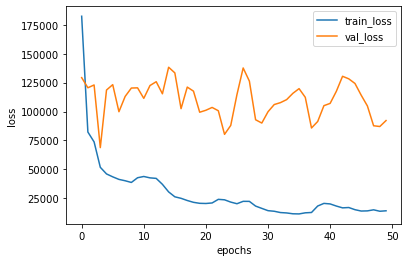

In [103]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## пример чтения сети из файла

In [118]:
#autoencoder_test = vanilla_autoencoder()
with torch.no_grad():
    autoencoder_test = torch.load('vanilla_auoencoder_00.pkl')
    autoencoder_test = autoencoder_test.to('cpu')
    for i, X_batch in enumerate(value_data):
        X_batch['profile'] = X_batch['profile'].to('cpu')
        reconstructed, embadding = autoencoder_test( X_batch['profile'] )
        loss = L(reconstructed, X_batch['profile'])
        #loss = L(reconstructed, X_batch[:, :(len(X_batch[0])-1)], embadding[:, :(len(embadding[0])-1)])
        if i==0:
            embaddings = customdataset(embadding, X_batch['ID'].copy())
            truth = customdataset(X_batch['profile'], X_batch['ID'].copy())
            pred = customdataset(reconstructed, X_batch['ID'].copy())
        else:
            embaddings.profile = torch.cat((embaddings.profile, embadding), 0)
            embaddings.name[len(embaddings.name):] = X_batch['ID']
            pred.profile = torch.cat((pred.profile, reconstructed), 0)
            pred.name[len(pred.name):] = X_batch['ID']
            truth.profile = torch.cat((truth.profile, X_batch['profile']), 0)
            truth.name[len(truth.name):] = X_batch['ID']
print(loss)
print(embaddings)

tensor(4.9312e-05)


## heat map

# Классификация


In [88]:
x_train, x_test, y_train, y_test = train_test_split (embaddings[:]['profile'], 
                                                     embaddings[:]['group'], train_size = 0.7)

In [89]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

RandomForestClassifier()

In [90]:
y_pred = classifier.predict(x_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  5  0  0 24  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  2  0  0  4  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  7  1  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0 10  0  0  0  0  0  0]
 [ 0  7  0  0  0  1  0  0  0  0  6  0  0 26  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  3  0  0 16  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  9  0  0 40  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  4  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0

C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mishs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


построение heat map, она показывает расстояние между средними векторами для каждой группы бактерий, на диагонали стоят средне-групповые расстояния 

In [70]:
def euclid (x):
    x = x**2
    l = np.sum(x)
    l = np.sqrt(l)
    return l

In [71]:
embaddings_heat = pd.DataFrame(embaddings[:]['profile'].numpy(), dtype = float)
print(len(embaddings[:]['ID']))
embaddings_heat['50'] = embaddings[:]['ID'] 
embaddings_heat.head()
embaddings_heat_mean = embaddings_heat.groupby('50').mean()
heat_map = np.zeros((len(embaddings_heat_mean.index), len(embaddings_heat_mean.index)))
heat_map = pd.DataFrame(heat_map, index=embaddings_heat_mean.index, 
                        columns=embaddings_heat_mean.index, dtype = float)
for i in embaddings_heat_mean.index:

    #для каждой группы ищем средне-групповое расстояние (ищем разность каждого ветора с каждым и делим на количество разностей) 
    mean = embaddings_heat.loc[embaddings_heat['50'] == i].drop(columns = ['50'], axis=1).to_numpy()
    s = np.zeros((len(mean[0])))
    count = 0
    for j in range (len(mean[:, 0])):
        for k in range (j+1, len(mean[:, 0])):
            s = s + mean[j] - mean[k]
            count = count + 1
    s = s/count
    e = euclid(s)
    heat_map.at[i, i] = e

    #ищем расстояние до средних векторов остальных групп mylist.index(element)
    for j in embaddings_heat_mean.index.values[np.where(embaddings_heat_mean.index.values == i)[0][0]: ]:
        s = embaddings_heat_mean.loc[i].to_numpy() - embaddings_heat_mean.loc[j].to_numpy()       
        e = euclid(s)
        heat_map.at[i, j] = e
print(heat_map.shape)    

3129
(74, 74)


полученная ранее матрица - верхне-треугольная, поэтому транспонируем ее, зануляем диагональ и складываем эти две матрицы

In [72]:
heat_map_t = heat_map.values.copy()
for i in range (len(heat_map['2U'])):
    heat_map_t[i, i] = 0
heat_map_t = heat_map_t.transpose()                  
heat_map.loc[ : , : ] = heat_map.values + heat_map_t     

рисуем heat map

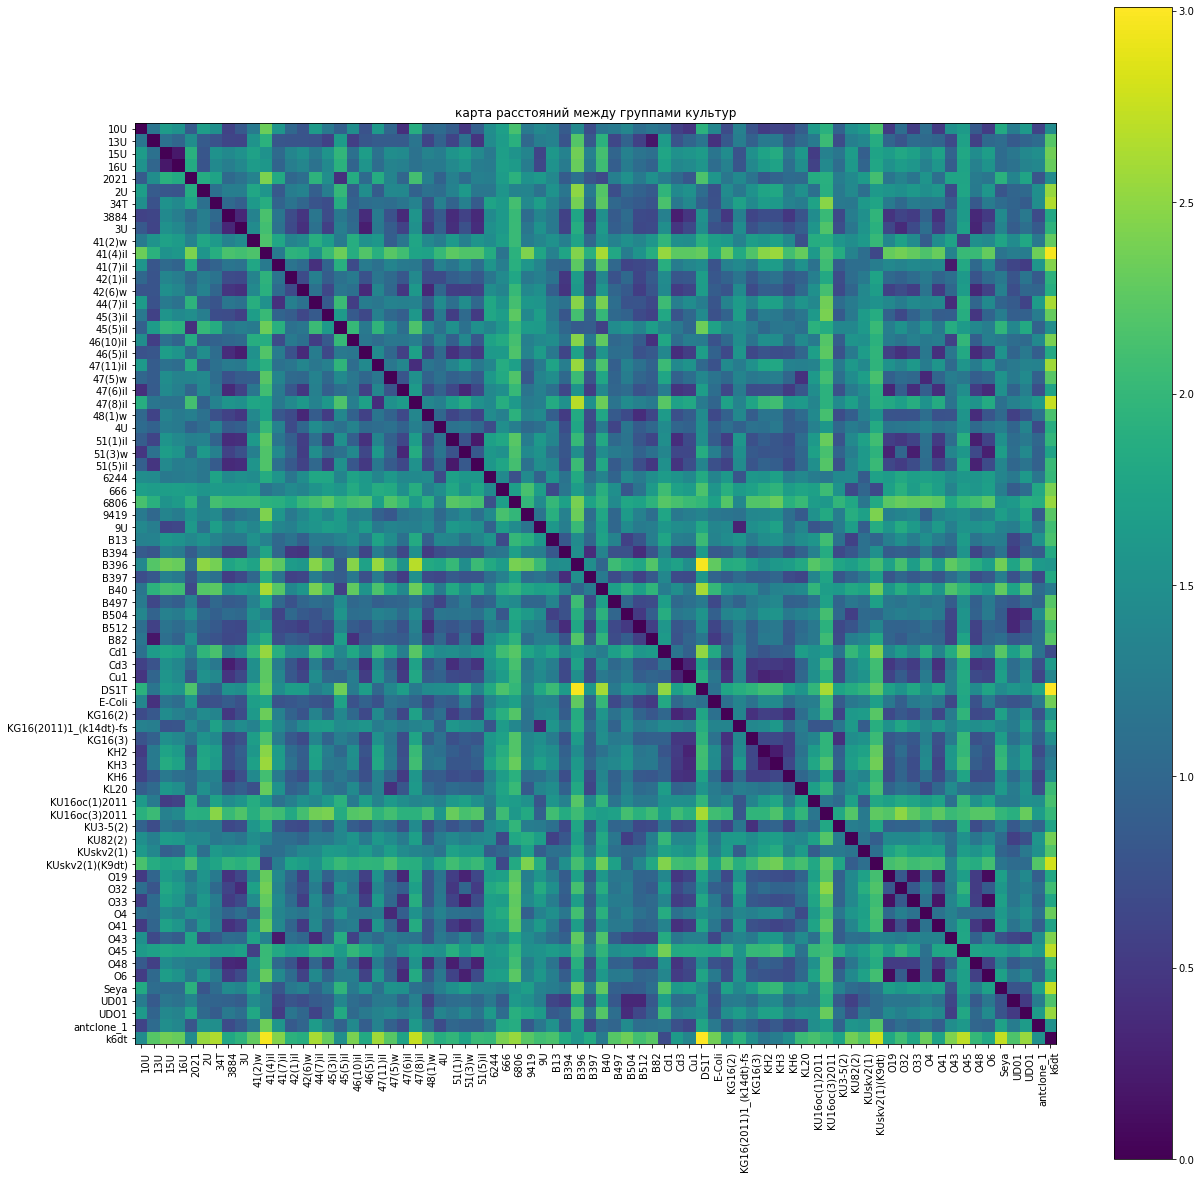

In [73]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks(np.arange(heat_map.shape[1]))
ax.set_yticks(np.arange(heat_map.shape[0]))
ax.set_xticklabels(heat_map)
ax.set_yticklabels(heat_map)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
im = ax.imshow(heat_map)
ax.set_title("карта расстояний между группами культур")
cbar = ax.figure.colorbar(im)
plt.show()